# !!! Change the Filename accordingly !!!

In [1]:
figure_name = 'figures/fig_2_response_'

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
# print(mpl.rcParams.keys())


In [18]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 8.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/20.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/4.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

In [19]:
len(t)

8001

In [20]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.jet,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) # * 1/( gaba_exc+1.0) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(gaba_inh+1.0)       
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q



In [21]:
############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))


kappas_r = [3]

############################################################
#                       Inputs                             #
############################################################
#                       Inputs                             #
############################################################

s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.0

### MNTB inhibitory input (contra-lateral) ###
gbc_center_frequencyBand =2
gbc_input_strength = 1.0

# build ramps
time_window = 400 # that equals a step of 5dB

for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = (i)/(len(t)-time_window) * gbc_input_strength


# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


# LSO direct excitatory input (ipsi-lateral)
sbc_center_frequencyBand = 2
sbc_input_strength = 1.0

# build ramps
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength


# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


# Convolve with gauss curve to build a temporal ramp
s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

# normalize input
maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
s_gbc_all /= maxi
s_sbc_all /= maxi

# correct for border effect of convolve
s_gbc_all[-250:,gbc_center_frequencyBand] = np.max(s_gbc_all[-250:])
s_sbc_all[:250,sbc_center_frequencyBand] = np.max(s_sbc_all[:250])


q_all = np.zeros((len(kappas_r),len(t),freq_bands))
r_all = np.zeros((len(kappas_r),len(t),freq_bands))
############################################################
#                      Simulation                          #
############################################################
for k in range(len(kappas_r)):
    kappa_r = kappas_r[k]
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):

            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(0,freq_bands),w,0.6)
            ie_kernel = gauss(np.arange(0,freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)
            
            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
            ii_kernel = np.zeros(freq_bands)


            delay_factor = 20
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel)       
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel)       
            
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)




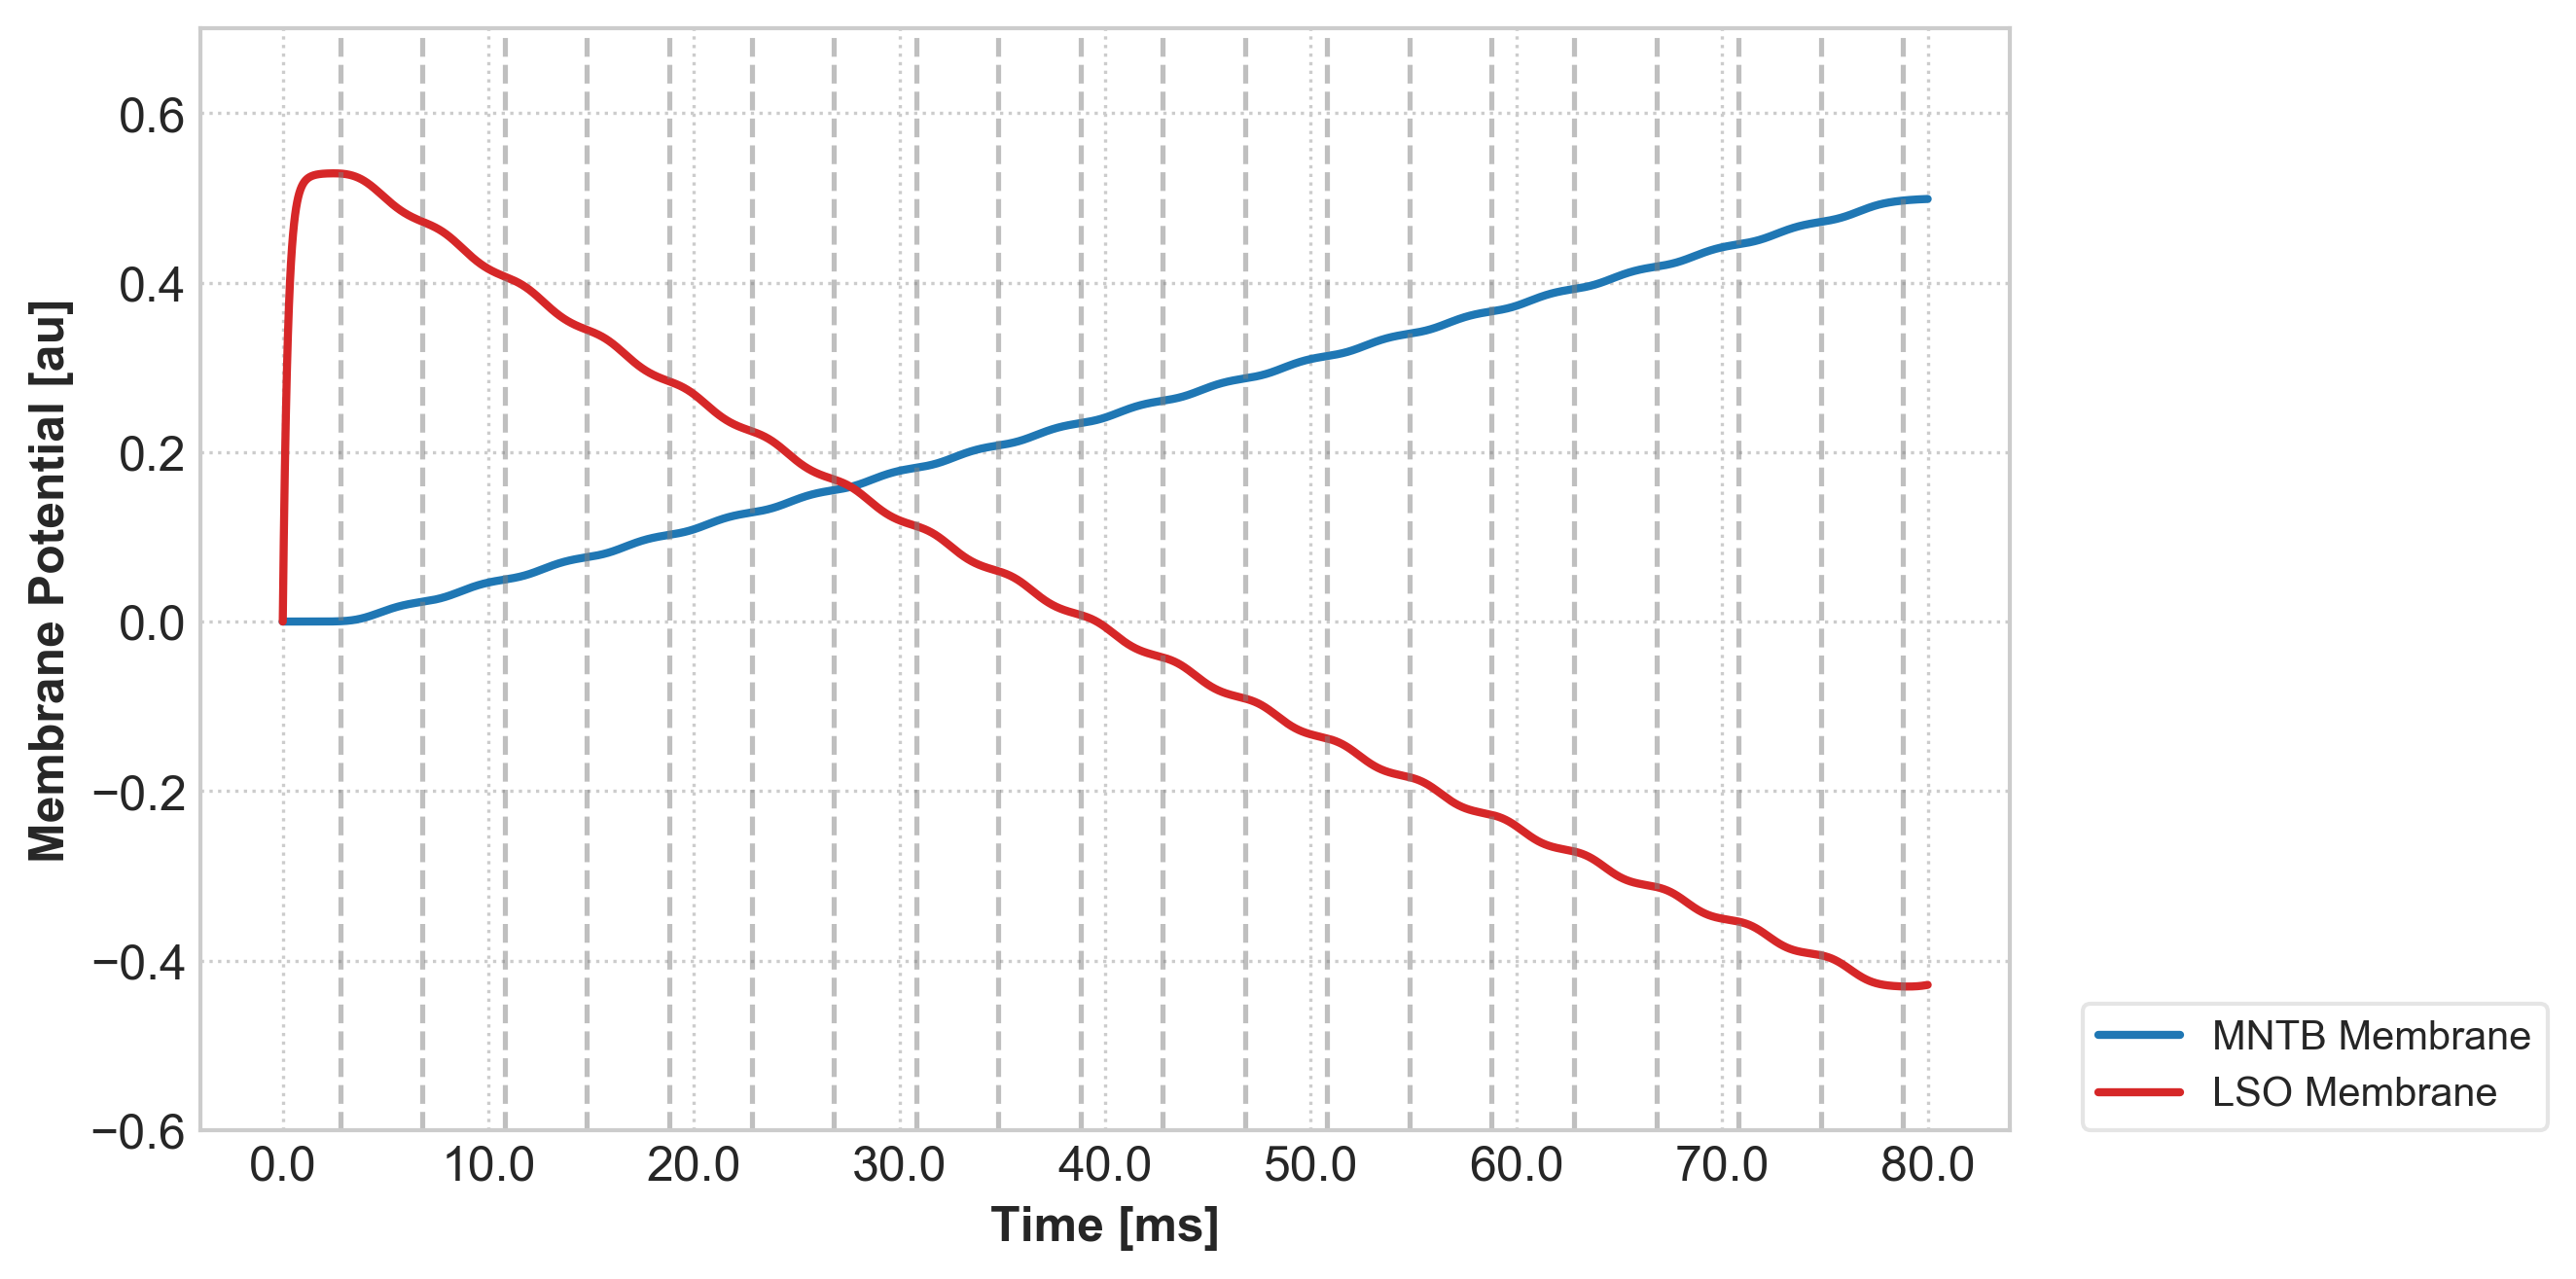

In [23]:
############################################################
#                       Plotting                           #
############################################################
probing_times = np.arange(280,len(t),time_window)

fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(len(kappas_r)):
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[:,sbc_center_frequencyBand]
    r = r_all[i,:,sbc_center_frequencyBand]
    q = q_all[i,:,sbc_center_frequencyBand]
    
    plt.plot(q,'C0',  label='MNTB Membrane')
    plt.plot(r,'C3',  label='LSO Membrane')

for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey',alpha = 0.5, linewidth = 1.25)

plt.ylim([-0.6,0.7])
    
# plt.title('Membrane Potentials')
plt.xlabel('Time [ms]')
ax1.set_xticklabels(ax1.get_xticks()/100)

plt.ylabel('Membrane Potential [au]')

lgd = plt.legend(loc=(1.04,0))

plt.savefig(figure_name + 'membrane_potentials.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'membrane_potentials.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'membrane_potentials.tiff', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()







In [24]:
# ############################################################
# #                       Plotting                           #
# ############################################################
# probing_times = np.arange(130,4000,200)

# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# for i in range(len(kappas_r)):
#     stri = 'k_r = {0:.1f}'.format(kappas_r[i])
#     diff_input =  s_gbc_all-s_sbc_all
#     diff_input = diff_input[:,sbc_center_frequencyBand]
#     q = q_all[i,:,sbc_center_frequencyBand]
#     plt.plot(q,label=stri)

# for i in probing_times:
#     plt.axvline(x=i,linestyle='--',color='grey',alpha = 0.5, linewidth = 2.5)

# plt.ylim([-0.6,0.7])
    
# plt.title('MNTB Neuron Membrane')
# plt.xlabel('Time [ms]')
# ax1.set_xticklabels(ax1.get_xticks()/100)

# plt.ylabel('Membrane Potential [au]')

# # lgd = plt.legend(loc=(1.04,0))

# plt.savefig(figure_name + 'mntb_membrane.svg') # bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'mntb_membrane.pdf') # bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.show()


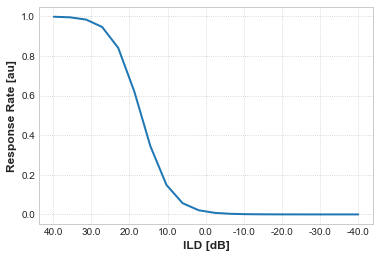

In [15]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
# plt.title('LSO Neuron Response Rate')

for i in range(len(kappas_r)):
    stri = 'k_r = {0:.1f}'.format(kappas_r[i])
    diff_input =  s_gbc_all-s_sbc_all
    diff_input = diff_input[:,sbc_center_frequencyBand]
    r = r_all[i,:,sbc_center_frequencyBand]
    plt.plot(-diff_input[probing_times],g_r_out(r[probing_times]),label=stri)
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax1.invert_xaxis()
# ax1.set_xticklabels([ round(k * 100) for k in ax1.get_xticks()])
l = [0]
l.extend(np.linspace(-40,40,len(ax1.get_xticklabels())-2))
ax1.set_xticklabels(l)

# lgd = plt.legend(loc=(1.04,0))


plt.savefig(figure_name + 'response.svg')# bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response.pdf')# bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()